# Human Image Background Remover

In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

## DATASET

In [51]:
def load_image(x):
    bytes = tf.io.read_file(x)
    img = tf.io.decode_png(bytes)
    return img  

In [52]:
def load_mask_image(x):
    bytes = tf.io.read_file(x)
    img = tf.io.decode_png(bytes,channels=1)
    return img

In [56]:
images = tf.data.Dataset.list_files('dataset\\images\\*.png', shuffle=False)
images = images.map(load_image)
images = images.map(lambda x: tf.image.resize(x, (256,256)))
images = images.map(lambda x: x/255)

In [57]:
masks = tf.data.Dataset.list_files('dataset\\masks\\*.png', shuffle=False)
masks = masks.map(load_mask_image)
masks = masks.map(lambda x: tf.image.resize(x, (256,256)))
masks = masks.map(lambda x: x/255)

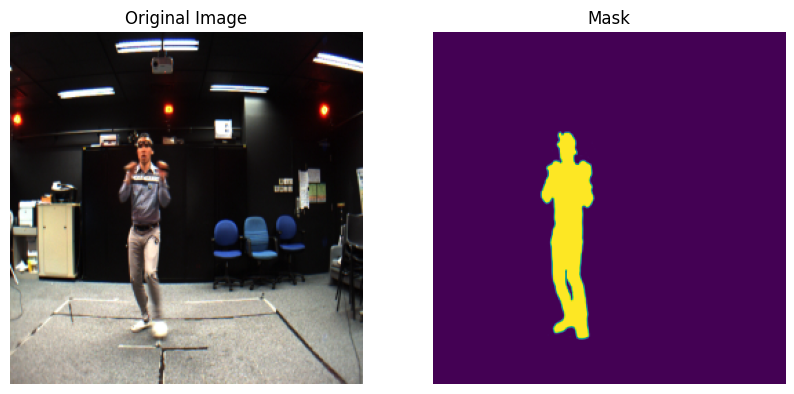

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(images.as_numpy_iterator().next())
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(masks.as_numpy_iterator().next())
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()


In [60]:
def u_net_model():

    input = layers.Input(shape=(256,256,3))

    # Down_Block 1
    conv1_1 = layers.Conv2D(64,3,activation="relu",padding="same")(input)
    conv1_2 = layers.Conv2D(64,3,activation="relu",padding="same")(conv1_1)
    pool_1 = layers.MaxPooling2D(2)(conv1_2)

    # Down_Block 2
    conv2_1 = layers.Conv2D(128,3,activation="relu",padding="same")(pool_1)
    conv2_2 = layers.Conv2D(128,3,activation="relu",padding="same")(conv2_1)
    pool_2 = layers.MaxPooling2D(2)(conv2_2)

    # Down_Block 3
    conv3_1 = layers.Conv2D(256,3,activation="relu",padding="same")(pool_2)
    conv3_2 = layers.Conv2D(256,3,activation="relu",padding="same")(conv3_1)
    pool_3 = layers.MaxPooling2D(2)(conv3_2)

    # BottleNeck
    conv4_1 = layers.Conv2D(512,3,activation="relu",padding="same")(pool_3)
    conv4_2 = layers.Conv2D(512,3,activation="relu",padding="same")(conv4_1)

    # Up_block 1
    upconv_1 = layers.Conv2DTranspose(256,2,strides=2,padding="same")(conv4_2)
    concat_1 = layers.concatenate([conv3_2,upconv_1])
    upconv1_1 = layers.Conv2D(256,3,activation="relu",padding="same")(concat_1)
    upconv1_2 = layers.Conv2D(256,3,activation="relu",padding="same")(upconv1_1)

    # Up_block 2
    upconv_2 = layers.Conv2DTranspose(128,2,strides=2,padding="same")(upconv1_2)
    concat_2 = layers.concatenate([conv2_2,upconv_2])
    upconv2_1 = layers.Conv2D(128,3,activation="relu",padding="same")(concat_2)
    upconv2_2 = layers.Conv2D(128,3,activation="relu",padding="same")(upconv2_1)
    
    # Up_block 3
    upconv_3 = layers.Conv2DTranspose(64,2,strides=2,padding="same")(upconv2_2)
    concat_3 = layers.concatenate([conv1_2,upconv_3])
    upconv3_1 = layers.Conv2D(64,3,activation="relu",padding="same")(concat_3)
    upconv3_2 = layers.Conv2D(64,3,activation="relu",padding="same")(upconv3_1)  
    
    # Output
    output = layers.Conv2D(1, (1,1), activation='sigmoid')(upconv3_2)

    model = models.Model(input,output)

    return model

In [26]:
model = u_net_model()

In [27]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_105[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 128, 128,  │          0 │ conv2d_106[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_30… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_107[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 64, 64,    │          0 │ conv2d_108[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_31… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 64, 64,    │    590,080 │ conv2d_109[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 32, 32,    │          0 │ conv2d_110[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_32… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 32, 32,    │  2,359,808 │ conv2d_111[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_20 │ (None, 64, 64,    │    524,544 │ conv2d_112[0][0]  │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 64, 64,    │          0 │ conv2d_110[0][0], │
│ (Concatenate)       │ 512)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 64, 64,    │  1,179,904 │ concatenate_16[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 64, 64,    │    590,080 │ conv2d_113[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_21 │ (None, 128, 128,  │    131,200 │ conv2d_114[0][0]

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimzer=tf.keras.optimizers.ADAM, loss=tf.keras.losses.)